In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# import shutil
# shutil.rmtree('/kaggle/working')

OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import os
import shutil
import random
import cv2

import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.layers import Dense 
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

In [3]:
#PARAMETERS
no_of_files = 1110 # <= 1114
img_size=(64,64,3)
lr=0.01
epochs=10

In [4]:
# dirname, folders, filenames =next( os.walk('../input/face-mask-usage'))

In [5]:
root_path='../input/face-mask-usage/'
work_path= '/kaggle/working/'

In [6]:
folders=['fully_covered','not_covered','not_face','partially_covered']

In [7]:
for folder in folders:
    makepath=work_path+str(folder)
    if(os.path.exists(makepath)==0):
        os.mkdir(makepath)

In [8]:
# sampling folders 1,2,3
for i in range(0,3):
    curfold=folders[i]
    path=root_path+str(curfold)
    print(path)
    _,_,filenames=next( os.walk(path))
    filenames=random.sample(filenames,no_of_files)
    for imagefile in filenames:
        src=root_path+curfold+'/'+str(imagefile)
        dest=work_path+curfold+'/'+str(imagefile)
        shutil.copy(src,dest)

# augmenting folder 4
_,_,filenames=next( os.walk(root_path+str(folders[3])))
                   
transform = A.Compose([A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2)])                 

../input/face-mask-usage/fully_covered
../input/face-mask-usage/not_covered
../input/face-mask-usage/not_face


In [9]:
i=1
_,_,filenames=next( os.walk(root_path+str(folders[3])))
for file in filenames:
    filepath=root_path+str(folders[3])+'/'+str(file)
    image=cv2.imread(filepath)
    savepath=work_path+str(folders[3])+'/'+str(file)
#     print(savepath)
    shutil.copy(filepath,savepath)
    
    transformed = transform(image=image)
    transformed_image = transformed["image"]
    
    imagename=file.split('.')[0]
    savepath=work_path+str(folders[3])+'/'
    cv2.imwrite(savepath+str(imagename)+str(i)+'.jpg', transformed_image)
    i+=1

In [10]:
_,_,filenames=next( os.walk('/kaggle/working/'+str(folders[3])))
len(filenames)

784

In [11]:
index=0
j=0
x_train=np.zeros((3*no_of_files+784,64,64,3),dtype=np.uint8)
y_train=np.zeros((3*no_of_files+784,1),dtype=np.uint8)

for i in range(0,4):
    curfold=folders[i]
    path=work_path+str(curfold)
    _,_,filenames=next( os.walk(path))
    for imagefile in filenames:
        impath=path+'/'+str(imagefile)
        image=cv2.imread(impath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#         image= np.expand_dims(image,axis=2)
#         print(image.shape)
#         break
        x_train[j]=image
        y_train[j]=index
        j+=1
        
    index+=1

In [12]:
# x_train.shape

In [13]:
# splitting
x_train, x_test, y_train, y_test = tts( x_train, y_train, test_size=0.15, random_state=42)
x_test, x_val, y_test, y_val = tts( x_test, y_test, test_size=0.15, random_state=42)

In [14]:
def classifier(img_shape=img_size):
    base_model=tf.keras.applications.MobileNetV2(input_shape=img_size,include_top=False,weights='imagenet')
    base_model.trainable=False
    inputs=tf.keras.Input(shape=img_size)
    x=preprocess_input(inputs)
    x=base_model(x,training=False)
    
    #multiclass classification layer
    x=tfl.GlobalAveragePooling2D()(x)
    x=tfl.Dropout(0.2)(x)
    
    outputs=Dense(4)(x)
    model=tf.keras.Model(inputs,outputs)
    
    return model

In [15]:
model=classifier(img_size)

2022-03-05 10:33:08.608737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 10:33:08.702175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 10:33:08.702886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 10:33:08.704006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124  

In [18]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=epochs)

2022-03-05 10:33:12.683961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-05 10:33:15.549062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 [==============================] - 10s 18ms/step - loss: 0.4760 - accuracy: 0.8678 - val_loss: 0.1436 - val_accuracy: 0.9355
Epoch 2/10
110/110 [==============================] - 1s 10ms/step - loss: 0.2168 - accuracy: 0.9299 - val_loss: 0.2556 - val_accuracy: 0.8817
Epoch 3/10
110/110 [==============================] - 1s 9ms/step - loss: 0.1854 - accuracy: 0.9414 - val_loss: 0.2488 - val_accuracy: 0.9032
Epoch 4/10
110/110 [==============================] - 1s 10ms/step - loss: 0.1467 - accuracy: 0.9542 - val_loss: 0.2576 - val_accuracy: 0.9032
Epoch 5/10
110/110 [==============================] - 1s 10ms/step - loss: 0.1439 - accuracy: 0.9585 - val_loss: 0.1716 - val_accuracy: 0.9677
Epoch 6/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1462 - accuracy: 0.9662 - val_loss: 0.1806 - val_accuracy: 0.9140
Epoch 7/10
110/110 [==============================] - 1s 9ms/step - loss: 0.1530 - accuracy: 0.9565 - val_loss: 0.2513 - val_accuracy: 0.9462
Epoch 8/10


In [19]:
# Evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print('Loss: %.2f' % (loss))
print('Accuracy: %.2f' % (accuracy*100))

17/17 [==============================] - 0s 14ms/step - loss: 0.2364 - accuracy: 0.9295
Loss: 0.24
Accuracy: 92.95


Evaluating network...


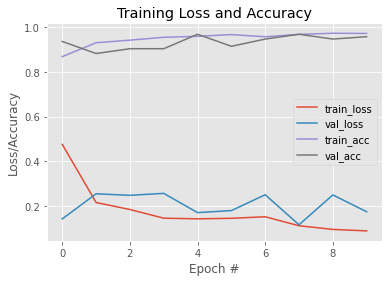

In [20]:
# evaluating and visual analysis of performance
print("Evaluating network...")
predictions = model.predict(x=x_test, batch_size=128)
# plot the training loss and accuracy
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

0 [0]


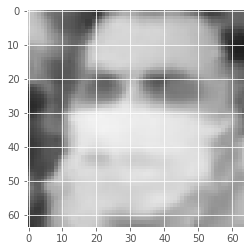

In [22]:
index=random.randint(0,x_test.shape[0])
plt.imshow(x_test[index])
print(np.argmax(predictions[index]),y_test[index])